# Ensure we install the latest version

Unfortunately `pip install qclib` does not install the latest state of the library, thus the examples do not work.

In [1]:
!pip uninstall qclib --yes

Found existing installation: qclib 0.0.13
Uninstalling qclib-0.0.13:
  Successfully uninstalled qclib-0.0.13


In [ ]:
!pip install git+https://github.com/qclib/qclib

# What do we need from the World?

In [3]:
import numpy as np
from qiskit import transpile, QuantumCircuit, quantum_info
from qiskit.providers.aer.backends import AerSimulator

# Construct an ideal simulator
backend = AerSimulator()
basis_gates=['cx', 'x', 'y', 'z', 'rx', 'ry', 'rz', 'h', 'u1', 'u2', 'u3']

# What do we need from `qclib`?

In [4]:
from qclib.state_preparation import BaaLowRankInitialize

## Initialize a vector, and create circuit with qiskit's `initialize()`

[0.12860182+0.10446439j 0.32643656+0.18017998j 0.25133689+0.14831232j
 0.20555493+0.09999622j 0.05357044+0.21008535j 0.05356216+0.04789651j
 0.01994355+0.10031057j 0.2974096 +0.12579373j 0.2063984 +0.15659585j
 0.24312327+0.26959743j 0.00706788+0.06855984j 0.33302752+0.17656715j
 0.28582689+0.20341103j 0.0729086 +0.01594918j 0.06243129+0.20860615j
 0.06297364+0.05855104j]
CX count 22


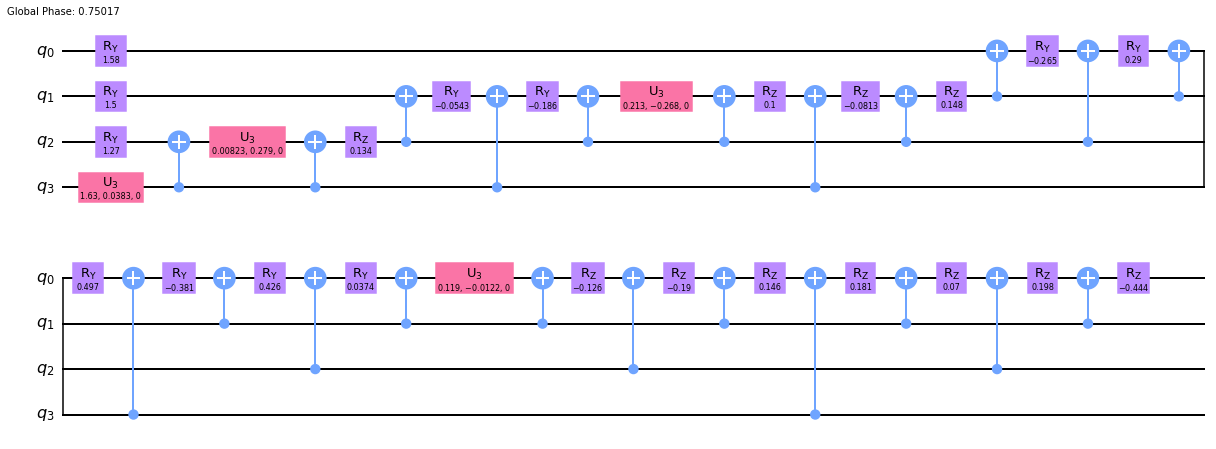

In [5]:
n = 4
rnd = np.random.RandomState(42)

input_vector = rnd.rand(2 ** n) + rnd.rand(2 ** n) * 1j
input_vector = input_vector / np.linalg.norm(input_vector)

print(input_vector)

circuit = QuantumCircuit(4)
circuit.initialize(input_vector)
circuit = transpile(circuit, backend, basis_gates=basis_gates)

print("CX count", circuit.count_ops()['cx'])
display(circuit.draw(output='mpl'))

## Initialize with BAA low rank algorithm with controlled fidelity loss

CX count 4


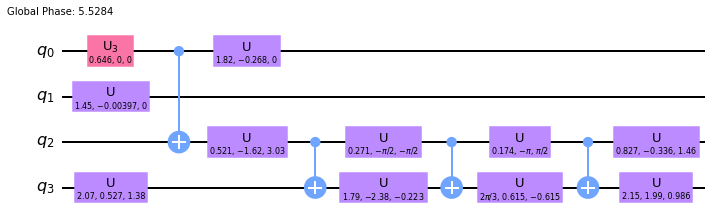

Equal: False
Fidelity: 0.8863725746981915


In [6]:
# Build a quantum circuit to initialize the input vector
circuit = BaaLowRankInitialize(
            input_vector, 
            opt_params={
                "max_fidelity_loss": 0.12,
                "strategy": "brute_force"
            }).definition
circuit = transpile(circuit, backend, basis_gates=basis_gates)
print("CX count", circuit.count_ops()['cx'])
display(circuit.decompose().decompose().draw(output='mpl'))


# Tests whether the produced state vector is equal to the input vector.
t_circuit = transpile(circuit, backend)
t_circuit.save_statevector()
state_vector = backend.run(t_circuit).result().get_statevector()
print('Equal:', np.allclose(state_vector, input_vector))
# Equal: True

print("Fidelity:", quantum_info.state_fidelity(state_vector, input_vector))

[If max_fidelity_loss input is lower than the estimated loss, it runs the full
routine with potentially exponential cost.](https://github.com/qclib/qclib/blob/d7eb25d27face49a26b6303cc7fd9976d68ccd29/qclib/state_preparation/util/baa.py#L78)

Building decision tree - [here is potentially leaky place](https://github.com/qclib/qclib/blob/d7eb25d27face49a26b6303cc7fd9976d68ccd29/qclib/state_preparation/util/baa.py#L253)